## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

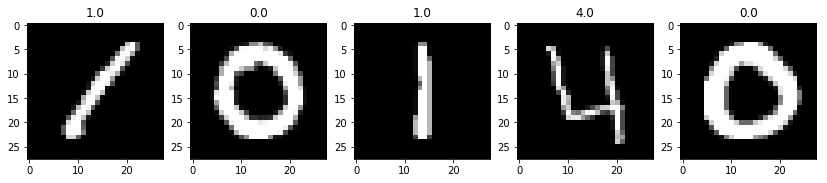

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [185]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=5)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=5)

In [186]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=5)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=5)

## Вычисляем угол и длину вектора градиента

In [187]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [188]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

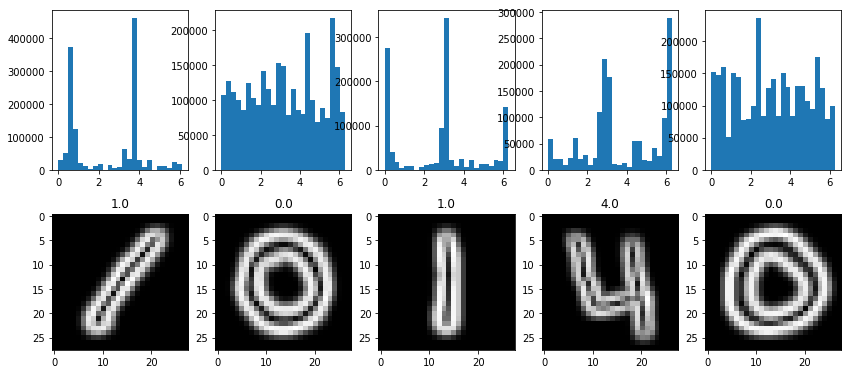

In [224]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=25, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [220]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 25))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=25,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [221]:
test_hist = np.zeros((len(test_img), 25))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=25,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [225]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [226]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [227]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

## Обучем модель логистической регрессии на наших данных 

In [228]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=500, verbose=1).fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.7s finished


In [229]:
pred_val = clf.predict(x_val)

## Оцениваем качество решения на валидационной выборке

In [230]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.61


In [231]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.39      0.32      0.35       816
         1.0       0.95      0.97      0.96       909
         2.0       0.50      0.38      0.43       846
         3.0       0.60      0.70      0.65       937
         4.0       0.63      0.64      0.64       839
         5.0       0.53      0.63      0.58       702
         6.0       0.47      0.44      0.45       785
         7.0       0.84      0.80      0.82       893
         8.0       0.46      0.54      0.50       835
         9.0       0.61      0.61      0.61       838

    accuracy                           0.61      8400
   macro avg       0.60      0.60      0.60      8400
weighted avg       0.61      0.61      0.61      8400



In [232]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[260   3  61  28  51  43 141   3 196  30]
 [  0 879   2   1  20   0   2   2   1   2]
 [ 41   0 322 177   7 162  38  17  69  13]
 [ 24   0  84 658   3  90   1   7  49  21]
 [ 31  31  11   4 539   0 101  22   9  91]
 [ 15   0  86  99   0 445   7   9  39   2]
 [125   2  31  20  89  21 342   9 104  42]
 [  4   8   8  15  19  13  26 712  16  72]
 [141   0  18  54  12  55  35  13 453  54]
 [ 29   2  15  33 114   6  30  53  42 514]]


## Предсказания на тестовыйх данных

In [233]:
pred_test = clf.predict(test_hist)

## Визуализируем предсказания

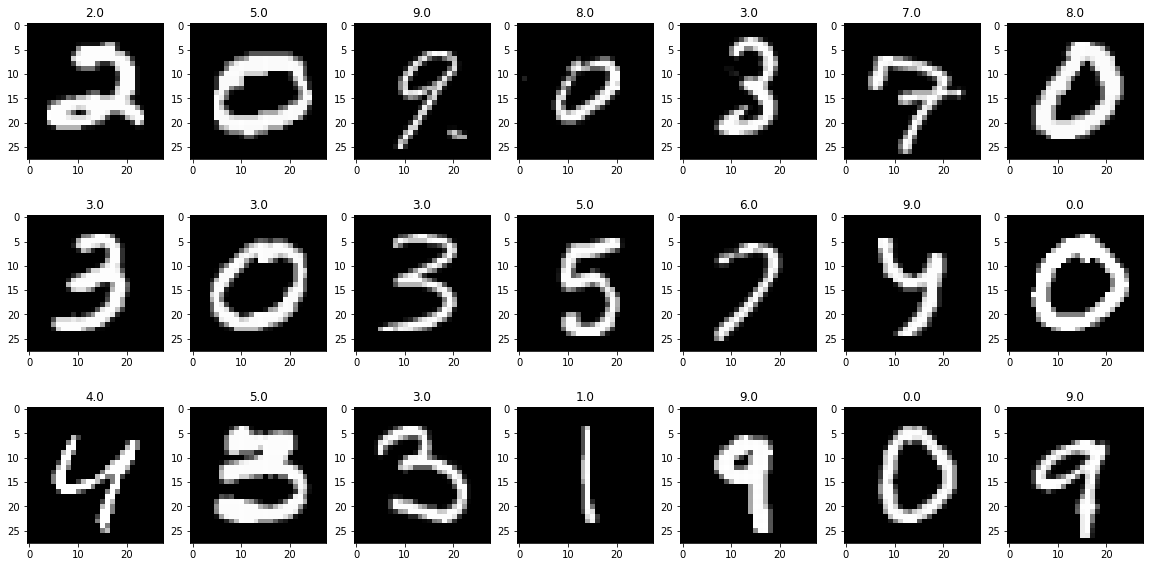

In [240]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:21], 1):
    subplot = fig.add_subplot(3, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [242]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [243]:
!head submit.txt

"head" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [237]:
# Your submission scored 0.41700